In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torchvision.transforms import v2

from torch.utils.data import DataLoader, random_split

In [2]:
# 디바이스 설정 (GPU 사용 가능 시 GPU 사용)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
train_dataset = datasets.MNIST(root='data',
                               train=True,
                               download=True)
test_dataset = datasets.MNIST(root='data',
                              train=False,
                              download=True)

In [4]:
print(f"train dataset len {len(train_dataset)}")
print(f"test dataset len {len(test_dataset)}")

train dataset len 60000
test dataset len 10000


In [5]:
train_dataset[0][0]
train_dataset.__getitem__(0)[0]

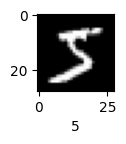

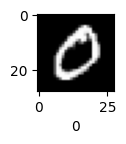

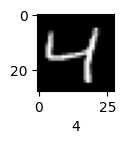

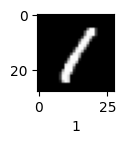

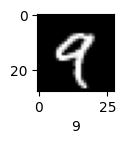

In [6]:
def visualize_data(image, label):
    class_names = range(10)
    plt.figure(figsize=(1,1))
    plt.imshow(image, cmap='gray')
    plt.xlabel(class_names[label])
    plt.show()

for i in range(5):
    image, label = train_dataset[i][0], train_dataset[i][1]
    visualize_data(image, label)

In [7]:
transforms = v2.Compose(
    [
        # transforms.ToTensor()
        v2.ToImage(),
        v2.ToDtype(dtype=torch.float32, scale=True)
    ]
)

In [8]:
train_dataset = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms,
)

test_dataset = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=transforms
)

In [9]:
image, label = train_dataset[0][0], train_dataset[0][1]
type(image)

torchvision.tv_tensors._image.Image

In [10]:
image

Image([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [12]:
class MLPAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        #encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [13]:
model_mlp = MLPAutoEncoder().to(device)

In [14]:
class CNNAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder= nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1), #28*28 -->14*14
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), #14*14 --> 7*7
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32,16, kernel_size=3, stride=2, padding=1, output_padding=1), # 7*7 --> 14*14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14*14 -->28*28
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [15]:
model_cnn = CNNAutoEncoder().to(device)

In [16]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=0.001)

In [17]:
for image, label in train_dataloader:
    print(image.shape)
    break
    # b, c, h, w --> pytorch
    # b, h ,w, c --> numpy

torch.Size([128, 1, 28, 28])


In [18]:
model_cnn(image.to(device)).shape

torch.Size([128, 1, 28, 28])

In [19]:
image.view(image.size(0), -1).shape

torch.Size([128, 784])

In [20]:
model_mlp(image.view(image.size(0), -1).to(device)).shape

torch.Size([128, 784])

In [21]:
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    for image, label in train_dataloader:
        image = image.view(image.size(0), -1).to(device)
        # image = image.to(device)
        label = label.to()
        
        pred = model_mlp(image)
        loss = loss_fn(pred, image)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        total_loss += loss.item()
    print(f'Epoch {epoch+1} / {epochs}, loss : {total_loss/len(train_dataloader)}')

Epoch 1 / 10, loss : 0.03339802159635878
Epoch 2 / 10, loss : 0.019535603740417372
Epoch 3 / 10, loss : 0.01769697710649291
Epoch 4 / 10, loss : 0.01684212918752737
Epoch 5 / 10, loss : 0.016356375606567747
Epoch 6 / 10, loss : 0.01601306714617939
Epoch 7 / 10, loss : 0.015777665837757242
Epoch 8 / 10, loss : 0.01561009550471105
Epoch 9 / 10, loss : 0.015479594475027721
Epoch 10 / 10, loss : 0.015413409748327122


In [22]:
model_mlp.eval()
with torch.no_grad():
    for image, label in test_dataloader:
        image = image.view(image.size(0), -1).to(device)
        pred = model_mlp(image)
        
        loss = loss_fn(pred, image)
        total_loss += loss.item()
    print(f'loss = {total_loss/len(test_dataloader)}')

loss = 0.10676850298348861


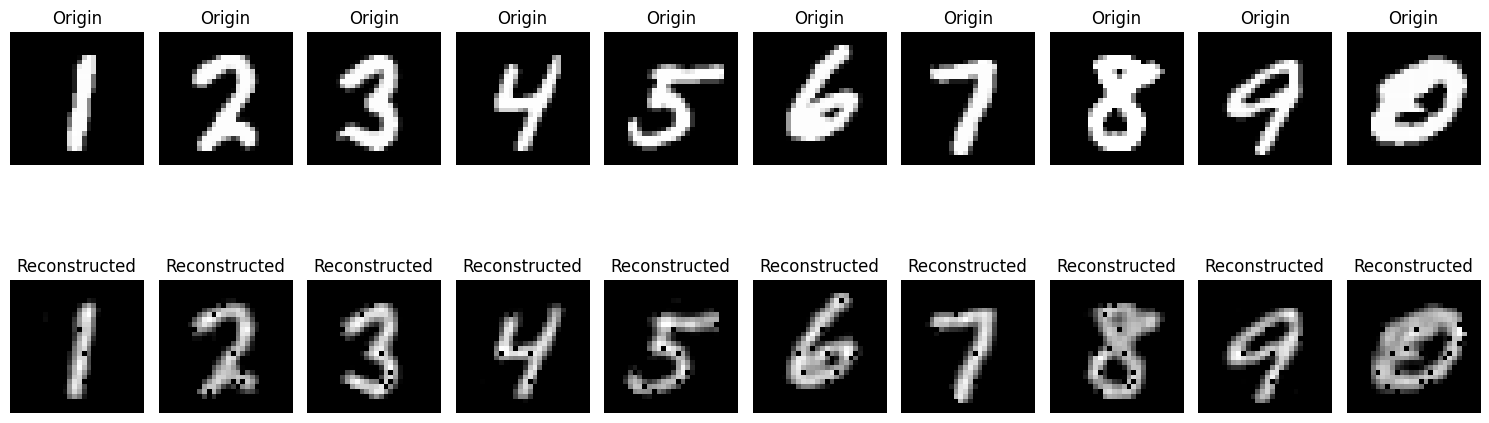

In [23]:
pred = pred.view(-1, 28, 28)
image = image.view(-1, 28, 28)

fig, axes = plt.subplots(2, 10, figsize=(15,6))

for i in range(10):
    axes[0, i].imshow(image[i].cpu().numpy(), cmap='gray')
    axes[0, i].set_title('Origin')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(pred[i].cpu().numpy(), cmap='gray')
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()    

In [24]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

In [25]:
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    for image, label in train_dataloader:
        # image = image.view(image.size(0),-1).to(device)
        image = image.to(device)
        label = label.to(device)

        pred = model_cnn(image)
        loss = loss_fn(pred, image)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
    print(f"epoch {epoch+1}/{epochs}, loss : {total_loss/len(train_dataloader)}")

epoch 1/10, loss : 0.019254179990369834
epoch 2/10, loss : 0.00145145288325036
epoch 3/10, loss : 0.0010106766985894155
epoch 4/10, loss : 0.0008068737459243901
epoch 5/10, loss : 0.0006803248636374897
epoch 6/10, loss : 0.0006018257371014925
epoch 7/10, loss : 0.0005505237843035094
epoch 8/10, loss : 0.0005110647928501878
epoch 9/10, loss : 0.00047935840814237367
epoch 10/10, loss : 0.00045354713603649647


In [26]:
model_cnn.eval()
total_loss = 0
with torch.no_grad():
    for image, label in test_dataloader:
        # image = image.view(image.size(0), -1).to(device)
        image = image.to(device)
        pred = model_cnn(image)

        loss = loss_fn(pred, image)
        total_loss += loss.item()
    print(f"loss = {total_loss/len(test_dataloader)}")

loss = 0.00043584281045212585


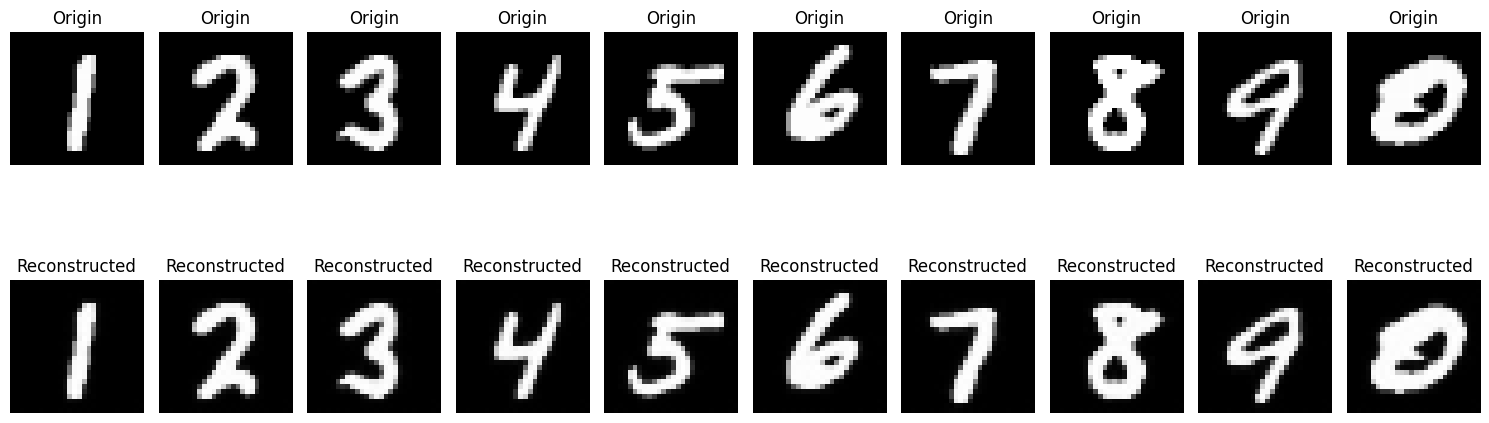

In [27]:
pred = pred.view(-1, 28, 28)
image = image.view(-1, 28, 28)

fig, axes = plt.subplots(2,10, figsize=(15,6))

for i in range(10):
    axes[0, i].imshow(image[i].cpu().numpy(), cmap='gray')
    axes[0, i].set_title('Origin')
    axes[0, i].axis('off')

    axes[1, i].imshow(pred[i].cpu().numpy(), cmap='gray')
    axes[1, i].set_title('Reconstructed')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [51]:
class AE_vis(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )

        self.decoder = nn.Sequential(
            nn.Linear(3,12),
            nn.ReLU(),
            nn.Linear(12,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def encode(self, x):
        return self.encoder(x)

In [52]:
model = AE_vis().to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [53]:
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    for image, label in train_dataloader:
        image = image.view(image.size(0), -1).to(device)
        pred = model(image)
        loss = loss_fn(pred, image)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss : {total_loss/len(train_dataloader)}")

Epoch 1/10, Loss : 0.10964413231878138
Epoch 2/10, Loss : 0.06741519909360007
Epoch 3/10, Loss : 0.06430607005508977
Epoch 4/10, Loss : 0.06096105318842158
Epoch 5/10, Loss : 0.05846056018048512
Epoch 6/10, Loss : 0.056798748854698655
Epoch 7/10, Loss : 0.05590641770217973
Epoch 8/10, Loss : 0.054989665619600045
Epoch 9/10, Loss : 0.0525788051773236
Epoch 10/10, Loss : 0.04964440099910886


In [54]:
all_latents = []
all_labels = []

model.eval()
with torch.no_grad():
    for image, label in test_dataloader:
        image = image.view(image.size(0),-1).to(device)
        latent = model.encode(image)
        pred = model(image)
        all_latents.append(latent.cpu().numpy())
        all_labels.append(label.cpu().numpy())

In [59]:
latent

tensor([[ 49.7501, -40.2641, -21.6145],
        [ 23.1355, -20.1691, -19.0002],
        [ 23.9369, -23.4076, -20.6368],
        [ 35.0799, -41.8142, -30.6209],
        [ 34.9845, -31.6362, -27.8685],
        [ 19.8251, -18.2039, -21.4189],
        [ 55.9934, -55.9462, -36.2546],
        [ 25.5435, -21.8134, -24.1561],
        [ 31.0293, -38.5177, -30.1637],
        [ 15.5447, -18.2835, -25.5251],
        [ 35.0051, -17.3042,  -9.3509],
        [ 11.5218,  -3.8451,  -9.7989],
        [  8.0627,  -8.8071, -11.6050],
        [ 47.6232, -47.5048, -35.5235],
        [ 32.0709, -27.1712, -22.1682],
        [ 11.0886, -15.4984, -17.6639]], device='cuda:0')

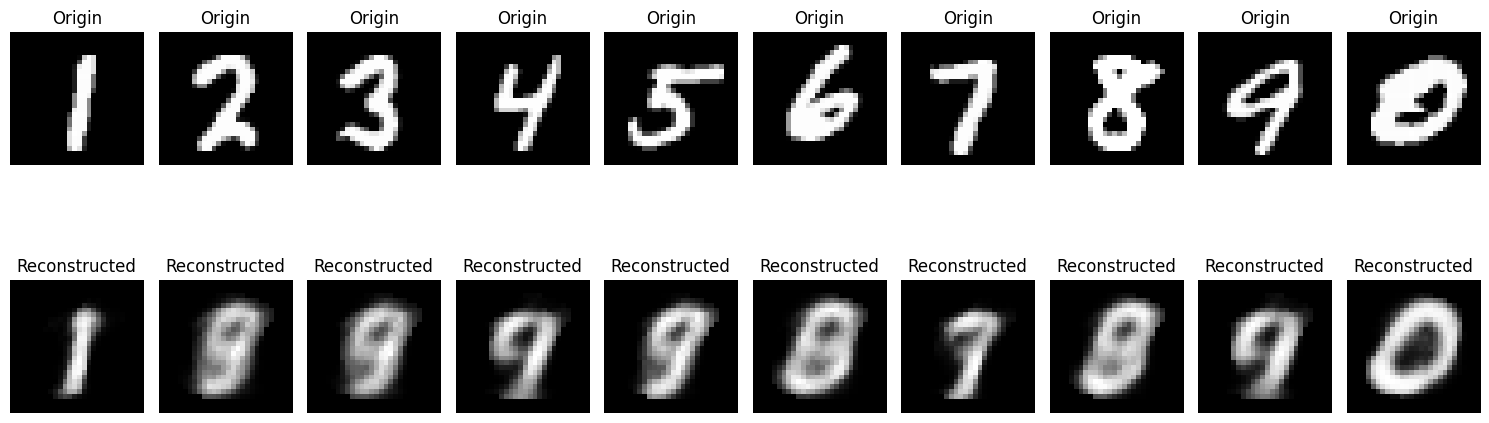

In [55]:
pred = pred.view(-1, 28, 28)
image = image.view(-1, 28, 28)

fig, axes = plt.subplots(2, 10, figsize=(15,6))
for i in range(10):
    axes[0,i].imshow(image[i].cpu().numpy(), cmap='gray')
    axes[0,i].set_title("Origin")
    axes[0,i].axis('off')

    axes[1,i].imshow(pred[i].cpu().numpy(), cmap='gray')
    axes[1,i].set_title("Reconstructed")
    axes[1,i].axis('off')

plt.tight_layout()
plt.show()

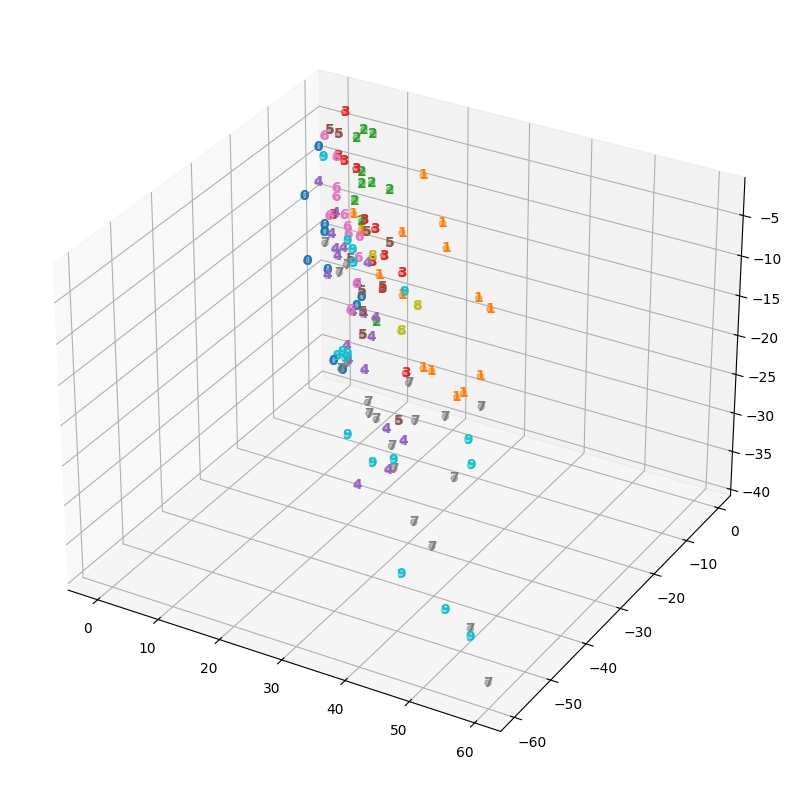

In [56]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(all_latents[0][:,0], all_latents[0][:,1], all_latents[0][:,2],c=all_labels[0], cmap='tab10', s=20, alpha=0.5)
for digit in range(10):
    indices = np.where(all_labels[0] == digit)[0]
    sample_indices = np.random.choice(indices, size=min(50, len(indices)), replace=False)

    for idx in sample_indices:
        x, y, z = all_latents[0][idx,0], all_latents[0][idx,1], all_latents[0][idx,2]
        ax.text(x, y, z, str(digit), color=plt.cm.tab10(digit), fontsize=10,
                fontweight='bold',
                ha='center',
                va='center')

plt.show()